## Applied Natural Language Processing - Method 2
Using PyTorch BERT

# 8. Other Method: BERT

## 8.1. Torch Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# !pip install transformers
# !pip install nlpaug

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset # for the usage of inputing the data to torch
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer,BertModel,get_linear_schedule_with_warmup 
import seaborn as sns
import nlpaug.augmenter.sentence as nas
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
torch.cuda.is_available()

True

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')
df=pd.read_csv('train.csv')
df.head()

,helpfulness_cat,imdb_user_review
0,1.0,It is hard to find such delightful and adorabl...
1,1.0,"They don't make films like this faded, hauntin..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...
3,1.0,I doubt that I'd ever seen anything resembling...
4,1.0,I was shocked to find myself riveted to this m...


## 8.2. Data Preprocessing
We apply the preprocess function, which is the same as the first notebook file

In [ ]:
def preprocess(text):
  pattern = re.compile(r'\s+')
  text=text.replace('\u202f',' ').replace('xa0',' ')
  text=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
  text=re.sub(r"\\u00b4",r'',text)
  text=re.sub(pattern, ' ', text)
  text = text.replace('?', ' ? ').replace(')', ') ').strip()
  return text

df['imdb_user_review']=df['imdb_user_review'].apply(preprocess)

## 8.3. Data Balancing ( Augmenting )
Bert-base & Generalization, Data Balancing

In [ ]:
def aug_abstract(text):
  aug = nas.abst_summ.AbstSummAug(model_path='t5-base')
  augmented_text=aug.augment(text) # augmented_text is the summary of the review
  return augmented_text

def aug_crop(text):
  aug1=naw.RandomWordAug(action='crop',aug_p=0.5) # Randomly delete sentences
  aug2=naw.SynonymAug(aug_src='wordnet') # synonym substitution
  aug3 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute") # Replace sentences based on context
  return aug3.augment(aug2.augment(aug1.augment(text))) 

df_aug=df[df['helpfulness_cat']==0].copy()
df_aug=df_aug.reset_index(drop=True)

df_aug['augmented_text1']=df_aug['imdb_user_review'].apply(aug_abstract)
df_aug['augmented_text2']=df_aug['imdb_user_review'].apply(aug_crop)

os.chdir('/content/drive/My Drive')
df_aug.to_csv('df_aug.csv')

In [ ]:
os.chdir('/content/drive/My Drive')
df_aug=pd.read_csv('df_aug.csv')

In [ ]:
def postprocess(text): # here we applied the same process and function for augmentation to balance the helpfulness_cat==0
  return text[2:-2]

df_aug1=df_aug.loc[:,('helpfulness_cat','augmented_text1')].rename(columns={"augmented_text1":"imdb_user_review"})
df_aug1['imdb_user_review']=df_aug1['imdb_user_review'].apply(postprocess) # apply the postprocess function to remove [] and ''
df_aug2=df_aug.loc[:,('helpfulness_cat','augmented_text2')].rename(columns={"augmented_text2":"imdb_user_review"})
df_aug2['imdb_user_review']=df_aug2['imdb_user_review'].apply(postprocess) # apply the postprocess function to remove [] and ''

In [ ]:
df_new=pd.concat((df,df_aug1,df_aug2),axis=0)
df_new['imdb_user_review']=df_new['imdb_user_review'].apply(preprocess)

## 8.4. Tokenization
1. The limitation for the model is with max token length for 512, so we set it here
2. Use the truncation to abandon the rest of the part
3. Note that inside the input, we could see:
  - tensor represent the token id
  - attention_mask represent whether that position has token or not
    - if not, the value would be zero
    - this could make the whole model to have consistant input shape
    - for the return_tensor, we could choose pt and tf, here is pt (pytorch)

In [ ]:
tokenizer=BertTokenizer.from_pretrained('bert-base-cased',do_lower_case=True) # there are other method such as case and uncase
# demostration of the single input
input=tokenizer(df['imdb_user_review'][0],padding='max_length',max_length=512,truncation=True,return_tensors='pt')
input

{'input_ids': tensor([[  101,  1122,  1110,  1662,  1106,  1525,  1216, 13657,  2365,  1105,
         27627,  5558,  1292,  1552,  1112,   165,   107,  1103,  5102,   165,
           107,   119,  1122,  1110,   170,  3826,  2523,  1133,  1177,  3987,
           117,  2183,  1105,  2712,  1115,  1128,  1274,   165,   190,  7629,
          1830,  1527,  1204, 24928,  3556,  1734,   119, 22572, 11478,  2836,
          1105,   127,   118,  1214,  1385,  1884, 26843,  1132,  3566,  1103,
          1211, 14186,  3111,   178,  1138,  1518,  1562,  1107,  1139,  1297,
           119,  1103,  1273, 28117, 19515,  8870,  1106,  1129, 22857,  1609,
          1105,  1554,  1104,  8730,  1133,  1145, 10827,  1193,  6782,  1105,
         17024,  1348,   119,   178,  1579,  1243,  1139,  1257,  1554,  1114,
          3632,  1104,  6782, 22834,  5800,  1105,  9266,   119,  1105,   178,
          1541,  1309,  5354,  1107,  5558,   119,  1105,  1103,  1390,   119,
           119,   119,  1157,  2566,  

In [ ]:
# Write it into the define function 
def tokenize(text):
  output=tokenizer(text,padding='max_length',max_length=512,truncation=True,return_tensors='pt') 
  return output

In [ ]:
class ReviewDataset(Dataset): # for the usage to input the data to pytorch
  def __init__(self,labels,texts):
    self.labels=labels
    self.texts=texts
    self.tokens=self.texts.apply(tokenize)
  
  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    token=self.tokens.iloc[idx]['input_ids'].squeeze(0)
    attention_mask=self.tokens.iloc[idx]['attention_mask'].squeeze(0)
    label=self.labels.iloc[idx]
    return token,attention_mask,label

## 8.5. Initializing Model

Here are the define functions for torch model usage, including: output accuracy, progress bar, and details checking

In [ ]:
def accuracy(output, target):
    y_pred = torch.softmax(output, dim=1)
    y_pred = torch.argmax(y_pred, dim=1).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred), f1_score(target,y_pred,average='macro')

class MetricMonitor:  # 像tf print出來的
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {'val': 0, 'count': 0, 'avg': 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric['val'] += val
        metric['count'] += 1
        metric['avg'] = metric['val'] / metric['count']

    def __str__(self):
        return '|'.join([
            "{metric_name}:{avg:.{float_precision}f}".format(
                metric_name=metric_name,
                avg=metric['avg'],
                float_precision=self.float_precision)
            for (metric_name, metric) in self.metrics.items()
        ])

def train(train_loader, model, criterion, optimizer, epoch): 
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)
  for (tokens, attention_masks, labels) in stream:
      tokens = tokens.to(device, non_blocking=True) # device should be all the same (either cpu or gpu)
      attention_masks = attention_masks.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True).long()
      output = model(tokens,attention_masks)
      loss = criterion(output, labels)
      f1_macro = accuracy(output, labels)[1]
      acc = accuracy(output, labels)[0]
      metric_monitor.update('loss', loss.item())
      metric_monitor.update('f1_score', f1_macro)
      metric_monitor.update('accuracy', acc)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      stream.set_description(
          "Epoch: {epoch}. Train: {metric_monitor}".format(
              epoch=epoch, metric_monitor=metric_monitor))
  return metric_monitor.metrics['accuracy']['avg']


def test(test_loader, model, criterion, epoch):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(test_loader)
  with torch.no_grad():
    for (tokens, attention_masks, labels) in stream:
      tokens = tokens.to(device, non_blocking=True)
      attention_masks = attention_masks.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True).long()
      output = model(tokens,attention_masks)
      loss = criterion(output, labels)
      f1_macro = accuracy(output, labels)[1]
      acc = accuracy(output, labels)[0]
      metric_monitor.update('loss', loss.item())
      metric_monitor.update('f1_score', f1_macro)
      metric_monitor.update('accuracy', acc)
      stream.set_description(
          "Epoch: {epoch}. Valid: {metric_monitor}".format(
              epoch=epoch, metric_monitor=metric_monitor))
  return metric_monitor.metrics['accuracy']['avg']

Usually the batch_size we obsreve is 16 to 32, but due to the limitation of computation, we would choose 2 here

In [ ]:
train_df,test_df=train_test_split(df_new,test_size=0.2,random_state=42,stratify=df_new['helpfulness_cat'])

train_dataset=ReviewDataset(train_df['helpfulness_cat'],train_df['imdb_user_review'])
test_dataset=ReviewDataset(test_df['helpfulness_cat'],test_df['imdb_user_review'])

batch_size=2
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

## 8.6. Bert Model Training

In [ ]:
class Bertclassifier(nn.Module): # Apply the bert model on torch
  def __init__(self,dropout=0.5):
    super().__init__()
    self.Bertclassifier=BertModel.from_pretrained('bert-base-cased') # bert-base-cased pre-train model
    self.dropout=nn.Dropout(dropout)
    self.linear=nn.Linear(768,2)

  def forward(self,input_ids,attention_mask):
    _,pooled_output=self.Bertclassifier(input_ids=input_ids,attention_mask=attention_mask,return_dict=False)
    lin,ear_output=self.linear(self.dropout(pooled_output))
    return linear_output

model=Bertclassifier().to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# here is the one single output from torch, we could see the shape is 2*2, which means the batch_size*binary_classfication
model(next(iter(train_loader))[0].to(device),next(iter(train_loader))[1].to(device))

tensor([[ 0.1965, -0.1569],
        [ 0.0221, -0.2126]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 8.7. Complie the model and make prediction 

In [ ]:
lr=1e-5
num_epochs=5
weight_decay=1e-8
# criterion=FocalLoss(weight=weight.to(device)).to(device)
criterion=nn.CrossEntropyLoss().to(device) #weight=
optimizer=torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=weight_decay)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0,
#                                             num_training_steps = len(train_df)//batch_size * num_epochs)

for epoch in range(1,num_epochs+1):
  train(train_loader,model,criterion,optimizer,epoch)
  test(test_loader,model,criterion,epoch)

Epoch: 1. Train: loss:0.554|f1_score:0.649|accuracy:0.717: 100%|██████████| 6335/6335 [14:34<00:00,  7.24it/s]
Epoch: 1. Valid: loss:0.404|f1_score:0.765|accuracy:0.814: 100%|██████████| 1584/1584 [01:11<00:00, 22.13it/s]
Epoch: 2. Train: loss:0.357|f1_score:0.802|accuracy:0.846: 100%|██████████| 6335/6335 [14:33<00:00,  7.25it/s]
Epoch: 2. Valid: loss:0.360|f1_score:0.794|accuracy:0.840: 100%|██████████| 1584/1584 [01:11<00:00, 22.24it/s]
Epoch: 3. Train: loss:0.187|f1_score:0.908|accuracy:0.929: 100%|██████████| 6335/6335 [14:33<00:00,  7.25it/s]
Epoch: 3. Valid: loss:0.372|f1_score:0.825|accuracy:0.865: 100%|██████████| 1584/1584 [01:11<00:00, 22.24it/s]
Epoch: 4. Train: loss:0.088|f1_score:0.959|accuracy:0.969: 100%|██████████| 6335/6335 [14:32<00:00,  7.26it/s]
Epoch: 4. Valid: loss:0.571|f1_score:0.785|accuracy:0.832: 100%|██████████| 1584/1584 [01:10<00:00, 22.34it/s]
Epoch: 5. Train: loss:0.055|f1_score:0.975|accuracy:0.982: 100%|██████████| 6335/6335 [14:32<00:00,  7.26it/s]
E

In [ ]:
model.eval()
prediction_list=torch.Tensor(0,1)
stream = tqdm(test_loader)
for (tokens, attention_masks, labels) in stream:
  tokens = tokens.to(device, non_blocking=True)
  attention_masks = attention_masks.to(device, non_blocking=True)
  labels = labels.to(device, non_blocking=True).long()
  output = model(tokens,attention_masks)
  prediction=torch.argmax(torch.softmax(output,dim=1),dim=1).reshape(-1,1).cpu()
  prediction_list=torch.cat((prediction_list,prediction),dim=0)

100%|██████████| 1584/1584 [01:04<00:00, 24.60it/s]


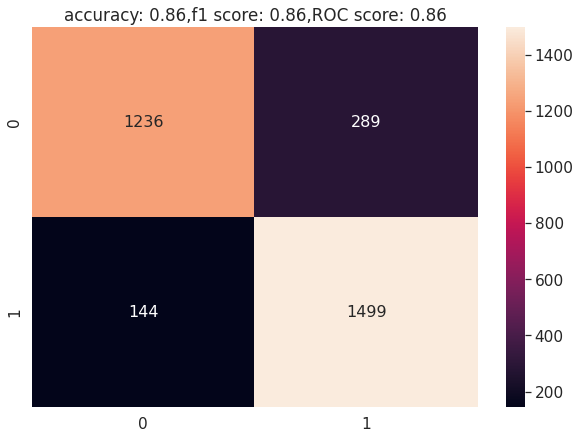

In [ ]:
y_pred=prediction_list.numpy()
y_true=test_df['helpfulness_cat'].values.reshape(-1,1)
array = confusion_matrix(y_true,y_pred)

df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f')
plt.title(
    f"accuracy: {accuracy_score(y_true, y_pred):.2f},f1 score: {f1_score(y_true,y_pred,average='macro'):.2f},ROC score: {roc_auc_score(y_true, y_pred, average='macro'):.2f}"
)
plt.show()

In [6]:
Micro_F1_score = 1499/(1499+1/2*(289+144))
Micro_F1_score

0.8737977266103177

In [ ]:
os.chdir('/content/drive/My Drive')
torch.save(model, './bert-base-text-classification.pth')

In [ ]:
df_test=pd.read_csv('https://raw.githubusercontent.com/tim5633/NLP_courseproject/main/NLP_dataset/test.csv?token=GHSAT0AAAAAABU22BL5QWGIF7QS7XSXXMPMYWMKQXA')
df_test['label']=0
def preprocess(text):
  text=text.replace('\u202f',' ').replace('xa0',' ')
  text=re.sub(r"\\u00b4+",r'',text)
  return text

df_test['imdb_user_review']=df_test['imdb_user_review'].apply(preprocess)
df_test.head()

,_id,imdb_user_review,label
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...,0
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei...",0
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...,0
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...,0
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...,0


In [ ]:
test_df=ReviewDataset(df_test['label'],df_test['imdb_user_review'])

batch_size=2
test_dl=DataLoader(dataset=test_df,batch_size=batch_size,shuffle=False,num_workers=2)
model.eval()
prediction_list=torch.Tensor(0,1)
stream = tqdm(test_dl)
for (tokens, attention_masks, labels) in stream:
  tokens = tokens.to(device, non_blocking=True)
  attention_masks = attention_masks.to(device, non_blocking=True)
  output = model(tokens,attention_masks)
  prediction=torch.argmax(torch.softmax(output,dim=1),dim=1).reshape(-1,1).cpu()
  prediction_list=torch.cat((prediction_list,prediction),dim=0)

100%|██████████| 2536/2536 [01:42<00:00, 24.73it/s]


In [ ]:
df_test['label']=prediction_list.squeeze(1).numpy()
df_test[df_test['label']==1].head(50)

,_id,imdb_user_review,label
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...,1.0
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei...",1.0
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...,1.0
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...,1.0
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...,1.0
5,610d01fe9a63eb113d22768c,MOROCCO is first and foremost an atmospheric f...,1.0
6,610d01fe9a63eb113d22a437,"Having recently seen the 1999 remake, I realiz...",1.0
7,610d01fe9a63eb113d22a9c2,Film chronicles the rise and fall of Tony Camo...,1.0
8,610d01fe9a63eb113d22b8c1,"I'm shocked, shocked at all the negative comme...",1.0
9,610d01fe9a63eb113d22b8c5,Many will say that Airplane or anything by Woo...,1.0


In [ ]:
# change the final_result column 'label' to 'helpfulness_cat'
df_test.rename(columns={'label':'helpfulness_cat'},inplace=True)
# drop the 'imdb_user_review' column
df_test.drop(columns=['imdb_user_review'],inplace=True)

# os.chdir('/content/drive/My Drive')
df_test.to_csv('final_result.csv', index=False)

In [18]:
# read the df_test
final_result=pd.read_csv('final_result.csv')
final_result

,Unnamed: 0,_id,helpfulness_cat
0,0,610d01fe9a63eb113d2235ac,1.0
1,1,610d01fe9a63eb113d224536,1.0
2,2,610d01fe9a63eb113d224d14,1.0
3,3,610d01fe9a63eb113d225f17,1.0
4,4,610d01fe9a63eb113d225f1a,1.0
...,...,...,...
5066,5066,610d02269a63eb113d5ecec2,1.0
5067,5067,610d02269a63eb113d5ecec4,0.0
5068,5068,610d02269a63eb113d5ececb,1.0
5069,5069,610d02269a63eb113d5ed17e,1.0
